# Titanic

In [1]:
# !pip install --upgrade scikit-learn==1.4.1.post1
# !pip install mlxtend 
# !pip install shap 
# pip install phik
# !pip install lightgbm
# импортируем необходимые библиотеки 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


# from mlxtend.plotting import plot_decision_regions

import scipy.stats as st
import numpy as np
import scipy as sp
import math

from phik.report import plot_correlation_matrix
import phik

from sklearn.linear_model import  LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from lightgbm import LGBMClassifier

from sklearn.metrics import(
                             roc_auc_score,
                             f1_score,
                             recall_score,
                             precision_score,
                             accuracy_score,
                             confusion_matrix
)




from sklearn.preprocessing import(
                                   StandardScaler,
                                   MinMaxScaler,
                                   OneHotEncoder,
                                   LabelEncoder,
                                   OrdinalEncoder,
                                   FunctionTransformer
)

from sklearn.impute import SimpleImputer


from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector, make_column_transformer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

# import shap
# Блок  импортов и настроек Optuna
import optuna
from optuna.integration import OptunaSearchCV 
from optuna import distributions
import logging
import warnings

optuna.logging.set_verbosity(optuna.logging.WARNING) # отключить вывод optunaSearchCV 
warnings.filterwarnings("ignore", category=optuna.exceptions.ExperimentalWarning) 


RANDOM_STATE = 50

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)



In [ ]:
# Загрузим  тренировочные и тестовые данные:

df_titanic = pd.read_csv('train.csv')

In [158]:
df_titanic_test =pd.read_csv('test.csv')

In [3]:
df_titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Названия столбцов - в нижний регистр.

In [4]:
df_titanic.columns = df_titanic.columns.str.lower()


In [5]:
df_titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  891 non-null    int64  
 1   survived     891 non-null    int64  
 2   pclass       891 non-null    int64  
 3   name         891 non-null    object 
 4   sex          891 non-null    object 
 5   age          714 non-null    float64
 6   sibsp        891 non-null    int64  
 7   parch        891 non-null    int64  
 8   ticket       891 non-null    object 
 9   fare         891 non-null    float64
 10  cabin        204 non-null    object 
 11  embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Есть пропуски в  столбцах 'Age', 'cabin', 'embarked'.

Заглушки  в столбцы   с пропусками : числовые -0 , str 'unknown'

In [6]:
df_titanic['age'] = df_titanic['age'].fillna(value=0)
df_titanic.fillna(value='unknown',inplace=True) 

In [7]:
df_titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  891 non-null    int64  
 1   survived     891 non-null    int64  
 2   pclass       891 non-null    int64  
 3   name         891 non-null    object 
 4   sex          891 non-null    object 
 5   age          891 non-null    float64
 6   sibsp        891 non-null    int64  
 7   parch        891 non-null    int64  
 8   ticket       891 non-null    object 
 9   fare         891 non-null    float64
 10  cabin        204 non-null    object 
 11  embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [8]:
df_titanic.fillna(value='unknown',inplace=True)         

In [9]:
df_titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  891 non-null    int64  
 1   survived     891 non-null    int64  
 2   pclass       891 non-null    int64  
 3   name         891 non-null    object 
 4   sex          891 non-null    object 
 5   age          891 non-null    float64
 6   sibsp        891 non-null    int64  
 7   parch        891 non-null    int64  
 8   ticket       891 non-null    object 
 9   fare         891 non-null    float64
 10  cabin        891 non-null    object 
 11  embarked     891 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Создадим функцию для  обработки  данных выполняющую:
- создание столбца с фамилиями пассажиров;
- создание столбца титулов
- заменяющую нули в 'age' по среднему значению  в титулах ( кроме Miss)
- Miss заполняет  по среднему, разделив на parch=0 (предположительно бе з родителей) и parch !=0

In [10]:
  def mod_date(data):
    
      # Столбец  с фамлиями
    data['family'] = data['name'].str.split(',').str[0].str.strip()
      
      # Столбец  с титулами
    data['titul'] =data['name'].str.split(',').str[1].str.split('.').str[0].str.strip()

    titul_age_zerro = list(data.query("age==0")['titul'].unique())
    # titul_age_zerro.remove('Miss')

    dict_titul_age={ x: data.query('age !=0 and titul == @x ').age.mean()     for x in titul_age_zerro  if x !='Miss'and x !='Ms'}  

    data['age']= data.apply(lambda x: dict_titul_age.get(x.titul, x.age) if x.age ==0 else x.age, axis=1)

    miss_age_small = data.query( "age !=0 and titul =='Miss' and parch !=0" )['age'].mean() 
    miss_age_larg = data.query( "age !=0 and titul =='Miss' and parch ==0" )['age'].mean()  

    data.loc[(data['age']==0) & (data['titul'] == 'Miss' ),'age']=\
    data.query( "age ==0 and titul =='Miss'").apply(lambda x:miss_age_small if x.parch !=0 else  miss_age_larg, axis=1 )
    data['age'] = data['age'].replace(0, 30) # костылик
    data['age']= data['age'].astype('int')
     
    data['deck'] = data.cabin.str[0]
      
    return data


In [11]:
df_titanic_new = mod_date(df_titanic)

Проверим распределение целвого признака:

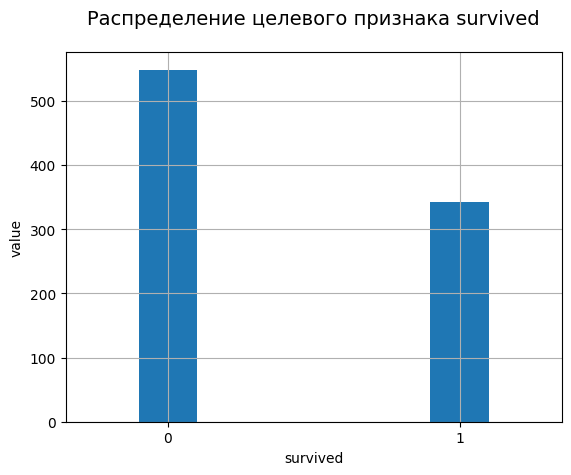

In [12]:
df_titanic_new['survived'].value_counts().plot(kind='bar', width=0.2, grid=True)
plt.xlabel('survived')
plt.ylabel('value')
plt.title('Распределение целевого признака survived', pad=20, fontsize=14)
plt.xticks(rotation=0)
plt.show()

Есть дисбаланс классов, при инициализации  моделей будем использовать class_weight='balanced'.

Удалим столбцы, которые не несут значимой информации для обучения модели: ['passengerid', 'name']

In [14]:
df_titanic_new.drop(['passengerid', 'name'], axis=1, inplace=True)

In [15]:
df_titanic_new

,survived,pclass,sex,age,sibsp,parch,ticket,fare,cabin,embarked,family,titul,deck
0,0,3,male,22,1,0,A/5 21171,7.2500,unknown,S,Braund,Mr,u
1,1,1,female,38,1,0,PC 17599,71.2833,C85,C,Cumings,Mrs,C
2,1,3,female,26,0,0,STON/O2. 3101282,7.9250,unknown,S,Heikkinen,Miss,u
3,1,1,female,35,1,0,113803,53.1000,C123,S,Futrelle,Mrs,C
4,0,3,male,35,0,0,373450,8.0500,unknown,S,Allen,Mr,u
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27,0,0,211536,13.0000,unknown,S,Montvila,Rev,u
887,1,1,female,19,0,0,112053,30.0000,B42,S,Graham,Miss,B
888,0,3,female,11,1,2,W./C. 6607,23.4500,unknown,S,Johnston,Miss,u
889,1,1,male,26,0,0,111369,30.0000,C148,C,Behr,Mr,C


Построим матрицу корреляции.

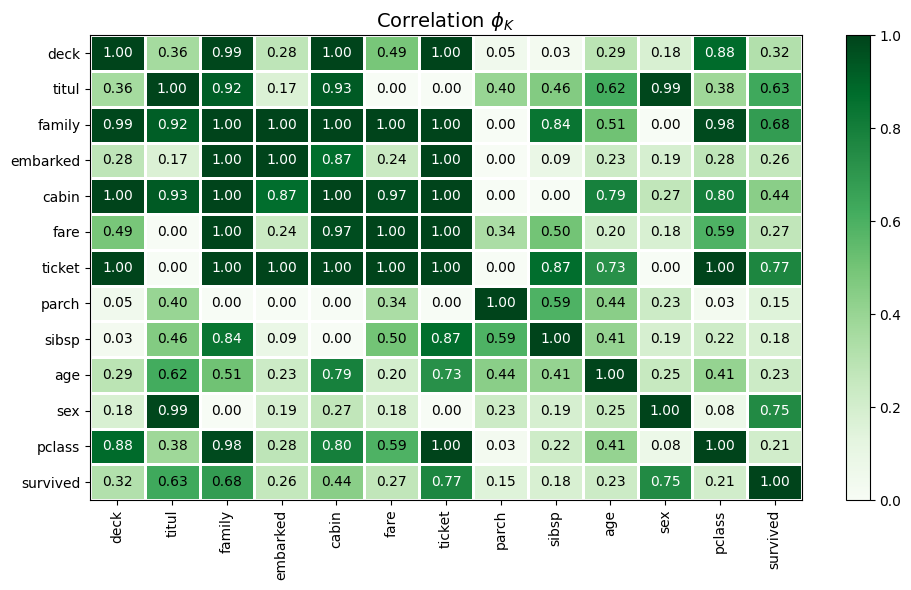

In [16]:
matrix_phik =df_titanic_new.phik_matrix(interval_cols=['age','fare']).round(2)

plot_correlation_matrix(
    matrix_phik.values,
    x_labels=matrix_phik.columns,
    y_labels=matrix_phik.index,
    vmin=0, vmax=1, color_map='Greens',
    # r'Correlation $\phi_K$'  Это часть строки, содержащая LaTeX-команду для отображения символа Фи с индексом K.
    # r raw _ обратный слэш просто как символ обратного слэша.
    title=r'Correlation $\phi_K$',
    fontsize_factor=1,
    figsize=(10, 6)
)

Удалим  признак 'ticket' 'family' из  датафрейма последующим причинам:
- мультикорреляция  с другими признаками;
- множество уникальных значений, не позволяющие модели выявить паттерны  и закономерности.

In [17]:
df_titanic_new.drop(['ticket','family'], axis=1, inplace=True)

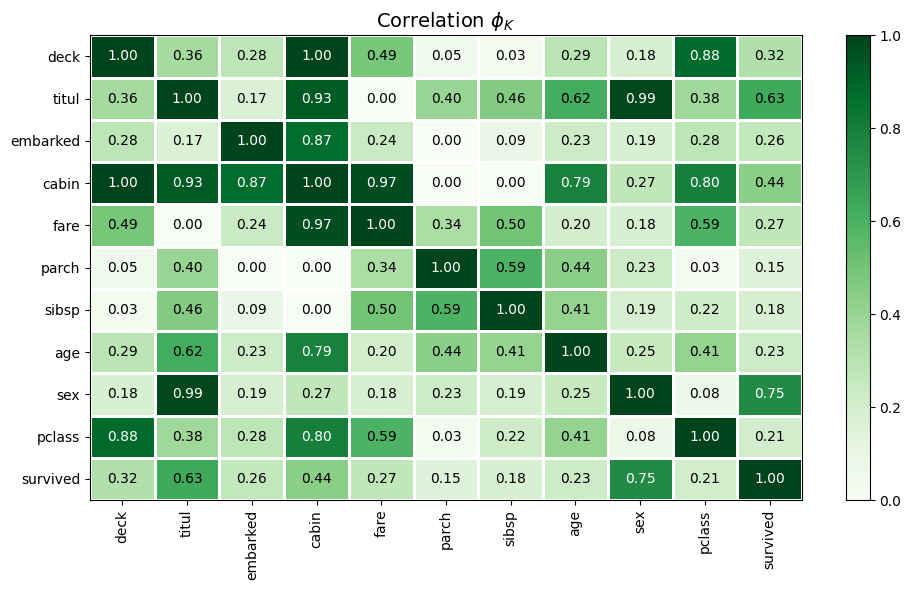

In [18]:
matrix_phik =df_titanic_new.phik_matrix(interval_cols=['age','fare']).round(2)

plot_correlation_matrix(
    matrix_phik.values,
    x_labels=matrix_phik.columns,
    y_labels=matrix_phik.index,
    vmin=0, vmax=1, color_map='Greens',
    # r'Correlation $\phi_K$'  Это часть строки, содержащая LaTeX-команду для отображения символа Фи с индексом K.
    # r raw _ обратный слэш просто как символ обратного слэша.
    title=r'Correlation $\phi_K$',
    fontsize_factor=1,
    figsize=(10, 6)
)

**drop_columns** -список столбцов, удаленных из датафрейма

In [19]:
drop_columns =['ticket','family','passengerid', 'name']

In [20]:
df_titanic_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   survived  891 non-null    int64  
 1   pclass    891 non-null    int64  
 2   sex       891 non-null    object 
 3   age       891 non-null    int32  
 4   sibsp     891 non-null    int64  
 5   parch     891 non-null    int64  
 6   fare      891 non-null    float64
 7   cabin     891 non-null    object 
 8   embarked  891 non-null    object 
 9   titul     891 non-null    object 
 10  deck      891 non-null    object 
dtypes: float64(1), int32(1), int64(4), object(5)
memory usage: 73.2+ KB


##  Соберем функцию для обработки тестовой таблицы.

In [156]:
# Функция для предподготовки данных: Названия столбцов - в нижний регистр +
# Заполнение пропусков.
def mod_date_pred (data):
    data= data.copy()
    data.columns = data.columns.str.lower()
    data['age'] = data['age'].fillna(value=0)
    # data['age'].fillna(value=0,inplace=True)
    data= data.fillna(value='unknown')
    return data

In [22]:
  def mod_date(data):

      # Столбец  с фамлиями
    data['family'] = data['name'].str.split(',').str[0].str.strip()
      
      # Столбец  с титулами
    data['titul'] =data['name'].str.split(',').str[1].str.split('.').str[0].str.strip()

    titul_age_zerro = list(data.query("age==0")['titul'].unique())
    # titul_age_zerro.remove('Miss')

    dict_titul_age={ x: data.query('age !=0 and titul == @x ').age.mean()     for x in titul_age_zerro  if x !='Miss'and x !='Ms'}  

    data['age']= data.apply(lambda x: dict_titul_age.get(x.titul, x.age) if x.age ==0 else x.age, axis=1)

    miss_age_small = data.query( "age !=0 and titul =='Miss' and parch !=0" )['age'].mean() 
    miss_age_larg = data.query( "age !=0 and titul =='Miss' and parch ==0" )['age'].mean()  

    data.loc[(data['age']==0) & (data['titul'] == 'Miss' ),'age']=\
    data.query( "age ==0 and titul =='Miss'").apply(lambda x:miss_age_small if x.parch !=0 else  miss_age_larg, axis=1 )
    data['age'] = data['age'].replace(0, 30) # костылик
    data['age']= data['age'].astype('int')
     
    data['deck'] = data.cabin.str[0]
      
    return data


In [23]:
# Функция  подготовки данных для теста( делает все тоже +  удаляет drop_columns
def mod_data_finale (data):
    
    data.drop(drop_columns, axis=1, inplace=True)   
    return data

In [133]:
def data_preprocessing(data):
    data= mod_date_pred (data)
    # data['fare'] = pd.to_numeric(data['fare'], errors='coerce').fillna(method='ffill')
    data['fare'] = pd.to_numeric(data['fare'], errors='coerce').ffill()
    data= mod_date(data)
    data=mod_data_finale(data)
    return data
     

## Подготовка данных  и обучение  моделей

In [25]:
df_titanic_new.head()

,survived,pclass,sex,age,sibsp,parch,fare,cabin,embarked,titul,deck
0,0,3,male,22,1,0,7.2500,unknown,S,Mr,u
1,1,1,female,38,1,0,71.2833,C85,C,Mrs,C
2,1,3,female,26,0,0,7.9250,unknown,S,Miss,u
3,1,1,female,35,1,0,53.1000,C123,S,Mrs,C
4,0,3,male,35,0,0,8.0500,unknown,S,Mr,u


Сохраним целевой признак в пременную y,  входные признаки в перменную X

In [26]:
X= df_titanic_new.drop('survived', axis=1)
y= df_titanic_new.survived

In [27]:
X.head()

,pclass,sex,age,sibsp,parch,fare,cabin,embarked,titul,deck
0,3,male,22,1,0,7.2500,unknown,S,Mr,u
1,1,female,38,1,0,71.2833,C85,C,Mrs,C
2,3,female,26,0,0,7.9250,unknown,S,Miss,u
3,1,female,35,1,0,53.1000,C123,S,Mrs,C
4,3,male,35,0,0,8.0500,unknown,S,Mr,u


In [28]:
y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 891 entries, 0 to 890
Series name: survived
Non-Null Count  Dtype
--------------  -----
891 non-null    int64
dtypes: int64(1)
memory usage: 7.1 KB


Отбирать модель будем по  метрике  на кроссвалидации.

Закодируем категориальные признаки  и отмасштабируем колличественные.

In [29]:
columns_num= ['age','fare']
column_сat= X.drop(columns_num, axis=1).columns.tolist()
print(columns_num, column_сat)

['age', 'fare'] ['pclass', 'sex', 'sibsp', 'parch', 'cabin', 'embarked', 'titul', 'deck']


Разделим категориальные признаки  на две группы:
- columns_cat_ord -  это группа признаков для кодирования c помощью OrdinalEncoder
- columns_cat_ohe -  эту группу закодируем  с помощью OneHotEncoder

In [30]:
columns_cat_ord=['cabin','titul']
columns_cat_ohe=[ x for x in column_сat if x not in columns_cat_ord]

In [31]:

print( f' columns_num -     {columns_num}','\n', f'columns_cat_ohe - {columns_cat_ohe}','\n',
      f'columns_cat_ord - {columns_cat_ord}')

 columns_num -     ['age', 'fare'] 
 columns_cat_ohe - ['pclass', 'sex', 'sibsp', 'parch', 'embarked', 'deck'] 
 columns_cat_ord - ['cabin', 'titul']


In [36]:
# пайплайн для кодирования бинарных категориальных  признаков.
ohe_pipe =Pipeline(
    [('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
        ]
) 




# пайплайн для кодирования категориальных признаков  c большим количеством значений .
ord_pipe = Pipeline(
    [
        ('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)),
        ('simple_imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
   ] 
)    

# пайплайн для плдоготовки данных, включающий кодирование категориальных и масштабирование 
# численных признаков.
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, columns_cat_ohe),
     ( 'ord', ord_pipe, columns_cat_ord),
     ('num', StandardScaler(), columns_num)
    ], 
    remainder='passthrough'
)


# финальный пайплайн включающий шаги по трансформации данных  и модель для обучения.
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
('models', LogisticRegression())
])
 # LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced',max_iter=100
# SVC(random_state=RANDOM_STATE,class_weight='balanced')

In [ ]:
# with warnings.catch_warnings():
     # warnings.filterwarnings("ignore", message="Found unknown categories")
     # result = cross_val_score(pipe_final, X, y, cv=10) 

In [37]:
param_model= [
        # словарь для модели Logisticregression
       {
    'models': [ LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced', penalty='elasticnet',solver='saga',max_iter=500)],
    'models__l1_ratio' : np.linspace(0, 1, 5),
     'models__C': np.linspace(0.1, 20, 20),
     'preprocessor__num': [StandardScaler()]
       },
    {
    'models':[ SVC(random_state=RANDOM_STATE,class_weight='balanced')],
         'models__kernel':['rbf','sigmoid'],
         'models__C': np.linspace(0.1, 20, 20),
         'models__gamma': np.linspace(0.1, 20, 20),
          'preprocessor__num': [StandardScaler()]
        }
       ]

In [38]:
grid_search = GridSearchCV(
    pipe_final, 
    param_model, 
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

In [39]:
%%time
grid_search.fit(X,y)

CPU times: total: 19.5 s
Wall time: 3min 37s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['pclass',
                                                                          'sex',
                                                                          'sibsp',
                                                                          'parch',
                                                                          'embarked',
                                                                          'deck']),
                                                                        ('ord',
                                                                         Pipeline(steps=[('ord',
                                                                                          OrdinalEncoder(handle_unknown='use_encoded_valu...
       15.81052632, 16.85789474, 17.90526316, 18.95263158, 20.        ]),
                          'models__gamma': array([ 0.1       ,  1.14736842,  2.19473684,  3.24210526,  4.28947368,
        5.33684211,  6.38421053,  7.43157895,  8.47894737,  9.52631579,
       10.57368421, 11.62105263, 12.66842105, 13.71578947, 14.76315789,
       15.81052632, 16.85789474, 17.90526316, 18.95263158, 20.        ]),
                          'models__kernel': ['rbf', 'sigmoid'],
                          'preprocessor__num': [StandardScaler()]}],
             scoring='accuracy')

In [51]:
print(f'Лучшая метрика {grid_search.best_score_}','\n')
print( 'Параметры лучшей модели :')
grid_search.best_params_

Лучшая метрика 0.8215554579122466 

Параметры лучшей модели :


{'models': SVC(class_weight='balanced', random_state=50),
 'models__C': 3.2421052631578946,
 'models__gamma': 0.1,
 'models__kernel': 'rbf',
 'preprocessor__num': StandardScaler()}

## LGBM модель

In [55]:
model = LGBMClassifier(
    boosting_type='gbdt',
    random_state=RANDOM_STATE,
    class_weight='balanced',
    verbosity=-1
)


pipe_lgbm = Pipeline([
    ('preprocessor', data_preprocessor),
('model', model)
])

In [56]:
pipe_lgbm

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['pclass', 'sex', 'sibsp',
                                                   'parch', 'embarked',
                                                   'deck']),
                                                 ('ord',
                                                  Pipeline(steps=[('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('simple_imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['cabin', 'titul']),
                                                 ('num', StandardScaler(),
                                                  ['age', 'fare'])])),
                ('model',
                 LGBMClassifier(class_weight='balanced', random_state=50,
                                verbosity=-1))])

In [57]:
param_model_lgb = { 
        'model__learning_rate': distributions.FloatDistribution(0.005, 0.05,step=0.001), # (default=0.1)
        'model__n_estimators':distributions.IntDistribution(100,1000,step=10), #(default=100)
        'model__num_leaves': distributions.IntDistribution(10,200), # (default=31)
        'model__reg_alpha' : distributions.FloatDistribution(0.0, 2.0, step=0.005),
        'model__reg_lambda': distributions.FloatDistribution(0.0, 2.0, step=0.005),
        'model__max_depth': distributions.IntDistribution(3, 16)
}

In [58]:
oscv = OptunaSearchCV(
        pipe_lgbm,
        param_model_lgb,
        scoring='accuracy',
        n_jobs=-1,
        cv=3,
        n_trials=500,
        random_state=RANDOM_STATE,
        verbose=False
    )

In [59]:
%%time



with warnings.catch_warnings():
     warnings.filterwarnings('ignore', category=UserWarning, module='sklearn.preprocessing._encoders')

     oscv.fit(X,y)

CPU times: total: 18min 52s
Wall time: 5min 50s


In [61]:
print(f'Лучшая метрика {oscv.best_score_}','\n')
print( 'Параметры лучшей модели :')
oscv.best_params_

Лучшая метрика 0.8361391694725028 

Параметры лучшей модели :


{'model__learning_rate': 0.047,
 'model__n_estimators': 960,
 'model__num_leaves': 192,
 'model__reg_alpha': 1.07,
 'model__reg_lambda': 1.6400000000000001,
 'model__max_depth': 6}

Для  тeстирования выберем модель случшей метрикой на кроссвалидации **oscv**

## Tестирование 

In [135]:
print( columns_num, columns_cat_ohe, columns_cat_ord)

['age', 'fare'] ['pclass', 'sex', 'sibsp', 'parch', 'embarked', 'deck'] ['cabin', 'titul']


Ознокомимся с тестовыми данными:

In [159]:
df_titanic_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [168]:
df_titanic_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB


Выполним предобработку, использую  собранную функцию **data_preprocessing**.
Ознокомимся с тестовым набором  предобрботанных данных.

In [160]:
X_test=data_preprocessing(df_titanic_test)

In [161]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pclass    418 non-null    int64  
 1   sex       418 non-null    object 
 2   age       418 non-null    int32  
 3   sibsp     418 non-null    int64  
 4   parch     418 non-null    int64  
 5   fare      418 non-null    float64
 6   cabin     418 non-null    object 
 7   embarked  418 non-null    object 
 8   titul     418 non-null    object 
 9   deck      418 non-null    object 
dtypes: float64(1), int32(1), int64(3), object(5)
memory usage: 31.2+ KB


In [142]:
pred =oscv.predict(X_test)

C:\Users\dmitr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [82]:
pred

array([0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,

Создадим датафрейм  с предсказанными значениями в столбце `Survived` и запишем  его в файл 'df_survived.csv'

In [166]:
df_test =df_titanic_test[['PassengerId']].copy()

df_test['Survived']=pred
df_test

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [112]:
df_test.to_csv('df_survived.csv', index=False)

Результат,засчитанный Kaggle:
Submitted by Dmitriss · Submitted 5 days ago

Score: 0.75837

Для улучшения результата нужно создать алгоритм заполнения  пропущенных значений столбца 'cabin', на основе имеющихся данных, учитывая связь с другими переменными, такими как класс, тариф, и порт отправления, это поможет повысить точность модели.

In [1]:
!pip freeze > env.txt